# Model Ensemble

En esta libreta exploramos técnicas de **ensamble de modelos** aplicadas al aprendizaje automático, una estrategia que busca combinar múltiples modelos base para mejorar la precisión, la robustez y la capacidad de generalización.

## Objetivo

El objetivo principal es familiarizarse con enfoques clásicos y modernos de ensamble, aplicarlos a un problema de clasificación y comparar su desempeño utilizando como única métrica de evaluación el **F1-score ponderado** (*f1_weighted*), que toma en cuenta el desequilibrio entre clases.

## Algoritmos de ensamble incluidos

- **Voting Classifier (Hard y Soft Voting)**  
  Combina las predicciones de varios clasificadores base mediante mayoría de votos (hard) o promediado de probabilidades (soft).

- **Random Forest**  
  Método basado en *bagging*, que construye múltiples árboles de decisión sobre subconjuntos aleatorios del conjunto de datos.

- **AdaBoost**  
  Algoritmo de *boosting* que entrena secuencialmente modelos débiles, ajustando los pesos para enfocarse en los errores previos.

- **XGBoost**  
  Variante eficiente y regularizada del boosting por gradiente, reconocida por su rendimiento superior en muchas tareas de clasificación.

---


## Instalación de dependencias

Para ejecutar esta libreta correctamente, es necesario instalar algunas bibliotecas adicionales que no siempre vienen preinstaladas en los entornos estándar de Python.

En particular:

- `xgboost` es una implementación eficiente del algoritmo de Boosting por Gradiente.
- `optuna` es una biblioteca de optimización que utilizaremos más adelante para ajustar hiperparámetros de algunos modelos (opcional pero útil).

La siguiente celda instalará estas dependencias. Si estás ejecutando esta libreta en Google Colab o un entorno limpio, puedes dejarla tal como está. En caso de que ya tengas estas bibliotecas instaladas, puedes omitirla.

**NOTA:** El resto de las librerias ya se encuentran instaladas en el ambiente de Google Colab por eso no se necesita instalación previa. En caso de usar la libreta de manera local se necesitará instalar todas las librerias faltantes

In [1]:
%%capture
!pip install optuna
!pip install xgboost

In [2]:
# Librerias básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# reprocesamiento
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

# Métricas y evaluación
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    make_scorer,
    roc_auc_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# Clasificadores base
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# Métodos de ensamble
from sklearn.ensemble import (
    VotingClassifier,
    StackingClassifier,
    BaggingClassifier,
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier
)

# XGBoost
import xgboost as xgb

# Optimización de hiperparámetros
import optuna

## Carga y preprocesamiento del conjunto de datos

Utilizaremos un conjunto de datos relacionado con la calidad del vino, el cual contiene variables fisicoquímicas (como acidez, pH, alcohol, etc.) y una columna de tipo (`red` o `white`). El objetivo es predecir la **calidad del vino** como una variable categórica.

Antes de entrenar los modelos, realizaremos algunos pasos de preprocesamiento:

- Cargamos los datos desde un archivo CSV.
- Convertimos la variable `type` a formato numérico (`0` para blanco y `1` para tinto).
- Eliminamos posibles valores faltantes.
- Agrupamos las clases de la variable `quality` para facilitar la clasificación:
  - Clases bajas (`3`, `4`, `5`) → **0**
  - Clase media (`6`) → **1**
  - Clases altas (`7` o más) → **2**
  
Esto transforma la tarea en un problema de clasificación multiclase con 3 niveles de calidad.


In [3]:
data = pd.read_csv('winequality.csv')
type_mapping = {'white': 0, 'red': 1}
data['type'] = data['type'].map(type_mapping)
data = data.dropna()
data["quality"] = data["quality"].replace({3:0, 4:0, 5:0, 6:1, 7:2, 8:2, 9:2, 10:2})
y =  data["quality"]
X = data.drop('quality', axis = 1)

## División del conjunto de datos y escalado

A continuación, dividimos el conjunto de datos en dos subconjuntos: **entrenamiento (80%)** y **prueba (20%)**, utilizando muestreo estratificado para conservar la proporción de clases en ambos subconjuntos.

Posteriormente, aplicamos una transformación combinada de escalado:

- Para la mayoría de las variables, usamos **StandardScaler**, que estandariza las características restando la media y dividiendo por la desviación estándar.
- Para la variable `pH`, que está acotada entre 0 y 14, aplicamos **MinMaxScaler** con ese rango específico.

Esta combinación se implementa usando un `ColumnTransformer` de scikit-learn, permitiendo aplicar diferentes transformaciones a diferentes columnas en un solo paso coherente.


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    stratify = y,
    test_size=0.20,
    random_state=21
)

standard_cols = [x for x in X.columns if x != 'pH']
minmax_cols = ['pH']

ct = ColumnTransformer(
    transformers=[
        ('std', StandardScaler(), standard_cols),
        ('minmax', MinMaxScaler(feature_range=(0, 14)), minmax_cols)
    ],
    remainder='passthrough'
)

ct.fit(X_train)
X_train_scaled = ct.transform(X_train)
X_test_scaled = ct.transform(X_test)

Definimos una función que nos ayudará a evaluar varios modelos

In [5]:
def evaluate_models(models, X_test, y_test, class_names=None):
    for model in models:
        print(f"\n Evaluating {model.__class__.__name__}...")
        y_pred = model.predict(X_test)
        print(classification_report(y_test, y_pred, target_names=class_names))

        # Matriz de confusión
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f"Confusion Matrix: {model.__class__.__name__}")
        plt.grid(False)
        plt.show()

## Random Forest

En esta sección entrenamos un modelo de **Random Forest**, uno de los métodos de ensamble más conocidos basado en bagging.

Para mejorar su rendimiento, utilizamos **Optuna**, una herramienta de optimización automática de hiperparámetros, que nos permitirá buscar de manera eficiente la mejor combinación de parámetros

Una vez entrenado el modelo con la mejor configuración, evaluamos su desempeño en el conjunto de prueba utilizando:

- **Classification report**, con especial atención al **F1-score ponderado (`f1_weighted`)**.
- **Matriz de confusión**, que nos permite visualizar los aciertos y errores por clase.


In [6]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'n_jobs': -1,
    }


    model = RandomForestClassifier(random_state=42, **{k: v for k, v in params.items() if v is not None})

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='f1_weighted', n_jobs=-1)

    return np.mean(scores)




In [7]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=1000, show_progress_bar=True)

[I 2025-10-11 01:29:48,328] A new study created in memory with name: no-name-8821f2e1-79f9-4668-8a32-9fc9084c13a8


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-10-11 01:29:57,828] Trial 0 finished with value: 0.6434309874338118 and parameters: {'n_estimators': 150, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 0 with value: 0.6434309874338118.
[I 2025-10-11 01:30:08,729] Trial 1 finished with value: 0.6080873488120793 and parameters: {'n_estimators': 350, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 0 with value: 0.6434309874338118.
[I 2025-10-11 01:30:13,820] Trial 2 finished with value: 0.6288357236244255 and parameters: {'n_estimators': 150, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 0 with value: 0.6434309874338118.
[I 2025-10-11 01:30:22,098] Trial 3 finished with value: 0.673206274288061 and parameters: {'n_estimators': 150, 'max_depth': 15, 'min_samples_split': 14, 'min_samples_leaf': 4, 'ma

In [8]:
study.best_params

{'n_estimators': 400,
 'max_depth': 15,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': None,
 'criterion': 'entropy'}

In [9]:
rf = RandomForestClassifier(**study.best_params, random_state=42)
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(criterion='entropy', max_depth=15, max_features=None,
                       min_samples_split=5, n_estimators=400, random_state=42)

In [10]:
print(classification_report(y_test, rf.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.74      0.75      0.74       475
           1       0.64      0.71      0.68       564
           2       0.75      0.56      0.64       254

    accuracy                           0.69      1293
   macro avg       0.71      0.67      0.69      1293
weighted avg       0.70      0.69      0.69      1293



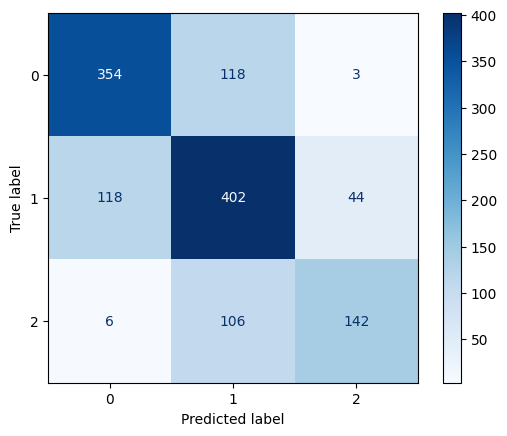

In [11]:
cm = confusion_matrix(y_test, rf.predict(X_test_scaled))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

## AdaBoost

En esta sección entrenamos un modelo de **AdaBoost** (*Adaptive Boosting*), una técnica de ensamble basada en el principio de combinar clasificadores débiles (por lo general árboles de decisión poco profundos) para formar un clasificador fuerte.

A diferencia de Random Forest, que entrena árboles en paralelo, **AdaBoost entrena secuencialmente**, enfocándose progresivamente en los ejemplos que los modelos anteriores clasificaron mal.


Como en el caso anterior, evaluamos el modelo con:

- **Classification report**, usando **F1-score ponderado** como métrica principal.
- **Matriz de confusión**, para observar el comportamiento del modelo en las distintas clases de calidad del vino.

In [12]:
# Diccionario de modelos
models = {
    "Tree (depth=3)": DecisionTreeClassifier(max_depth=3),
    "Tree (depth=4)": DecisionTreeClassifier(max_depth=4),
    "Tree (depth=5)": DecisionTreeClassifier(max_depth=5),
    "Tree (depth=6)": DecisionTreeClassifier(max_depth=6),
    "Tree (depth=7)": DecisionTreeClassifier(max_depth=7),
    "Tree (depth=8)": DecisionTreeClassifier(max_depth=8),
    "Logistic Regression": LogisticRegression(solver='liblinear'),
    "Gaussian NB": GaussianNB(),
}

# Entrenamos y evaluamos cada uno
results = {}

for name, weak_learner in models.items():
    print(f"Entrenando AdaBoost con {name}")
    model = AdaBoostClassifier(estimator=weak_learner, n_estimators=200, random_state=42)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc


Entrenando AdaBoost con Tree (depth=3)
Entrenando AdaBoost con Tree (depth=4)
Entrenando AdaBoost con Tree (depth=5)
Entrenando AdaBoost con Tree (depth=6)
Entrenando AdaBoost con Tree (depth=7)
Entrenando AdaBoost con Tree (depth=8)
Entrenando AdaBoost con Logistic Regression
Entrenando AdaBoost con Gaussian NB


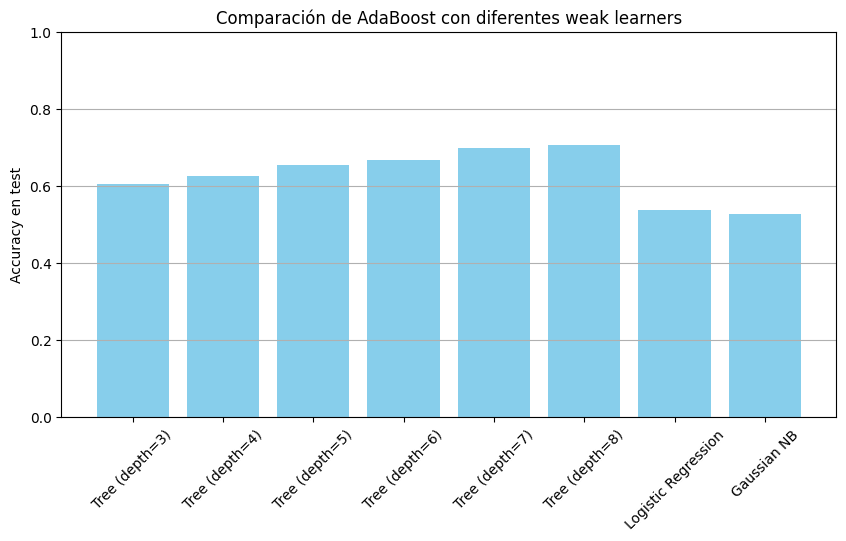

In [13]:
# Mostrar resultados
plt.figure(figsize=(10, 5))
plt.bar(results.keys(), results.values(), color='skyblue')
plt.title('Comparación de AdaBoost con diferentes weak learners')
plt.ylabel('Accuracy en test')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()


In [14]:
adaptiveboosting = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=8), n_estimators=200, random_state=42)

In [15]:
adaptiveboosting.fit(X_train_scaled, y_train)
y_pred = adaptiveboosting.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.68      0.72       475
           1       0.65      0.76      0.70       564
           2       0.78      0.64      0.70       254

    accuracy                           0.71      1293
   macro avg       0.73      0.69      0.71      1293
weighted avg       0.72      0.71      0.71      1293



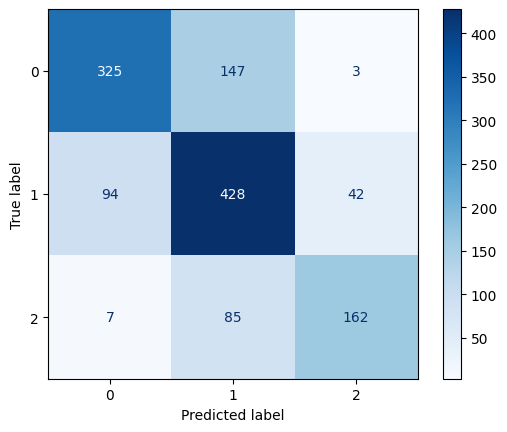

In [16]:
cm = confusion_matrix(y_test, adaptiveboosting.predict(X_test_scaled))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

## XGBoost

En esta sección aplicamos el algoritmo **XGBoost** (*Extreme Gradient Boosting*), una implementación altamente eficiente y regularizada del método de boosting por gradiente.

XGBoost ha demostrado un excelente rendimiento en una amplia variedad de tareas de clasificación debido a su capacidad para:

- Manejar valores faltantes internamente.
- Incorporar regularización (L1 y L2) para prevenir el sobreajuste.
- Ejecutarse de forma rápida y paralelizada.

Para ajustar el modelo a nuestro conjunto de datos, utilizamos **Optuna** para buscar automáticamente la mejor combinación de hiperparámetros

In [17]:
def objective(trial):
    param = {
        'verbosity': 0,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'booster': 'gbtree',
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5)
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    model = xgb.XGBClassifier(**param, use_label_encoder=False)
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1_weighted').mean()
    return score


In [18]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2025-10-11 01:43:37,493] A new study created in memory with name: no-name-7cf35a3b-94ed-4586-a3a1-723cc44964ec
[I 2025-10-11 01:43:41,261] Trial 0 finished with value: 0.643407447132111 and parameters: {'n_estimators': 242, 'max_depth': 7, 'learning_rate': 0.030644966905404553, 'subsample': 0.6639985362143961, 'colsample_bytree': 0.6118081099959474, 'gamma': 0.9518144341652035, 'min_child_weight': 8, 'reg_alpha': 2.1531041893196097, 'reg_lambda': 2.531145978163458}. Best is trial 0 with value: 0.643407447132111.
[I 2025-10-11 01:43:42,829] Trial 1 finished with value: 0.6588554715444347 and parameters: {'n_estimators': 74, 'max_depth': 10, 'learning_rate': 0.15111176456710448, 'subsample': 0.6028378535571604, 'colsample_bytree': 0.9789894136606623, 'gamma': 1.5390436343905738, 'min_child_weight': 1, 'reg_alpha': 0.15837782499474928, 'reg_lambda': 2.1138213544245765}. Best is trial 1 with value: 0.6588554715444347.
[I 2025-10-11 01:43:43,880] Trial 2 finished with value: 0.6001166937

In [19]:
xgboost_model = xgb.XGBClassifier(**study.best_params)
xgboost_model.fit(X_train_scaled, y_train)
y_pred = xgboost_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.73      0.72       475
           1       0.63      0.67      0.65       564
           2       0.70      0.57      0.63       254

    accuracy                           0.67      1293
   macro avg       0.68      0.66      0.67      1293
weighted avg       0.68      0.67      0.67      1293



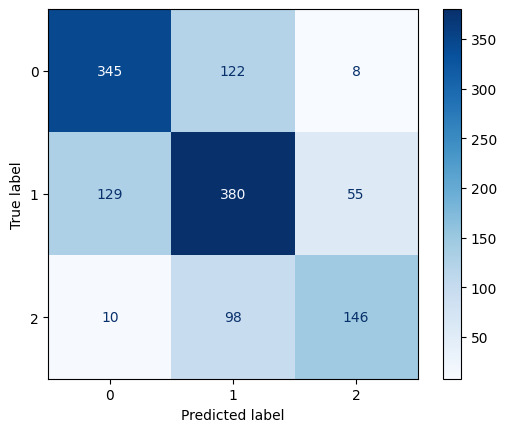

In [20]:
cm = confusion_matrix(y_test, xgboost_model.predict(X_test_scaled))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

## Ensamble por votación

Ahora que hemos entrenado tres modelos potentes de clasificación —**Random Forest**, **AdaBoost** y **XGBoost**—, construiremos un **modelo de ensamble por votación** utilizando el `VotingClassifier` de scikit-learn.

La idea detrás del ensamble por votación es simple pero poderosa: combinar las predicciones de múltiples modelos para tomar una decisión conjunta. Esto suele mejorar la robustez y generalización del sistema.

### Tipos de votación:

- **Hard Voting**: Cada modelo vota por una clase y la clase con más votos gana. Es útil cuando los modelos individuales son fuertes y relativamente diversos.
- **Soft Voting**: Se promedian las probabilidades de predicción de cada clase (cuando los modelos las proveen) y se escoge la clase con mayor probabilidad media. Suele ofrecer mejores resultados cuando los modelos están bien calibrados.

Usaremos los modelos previamente entrenados (con sus mejores parámetros en caso de haberlos optimizado) como base para este ensamble, y evaluaremos su rendimiento de forma consistente con las métricas anteriores:

- **F1-score ponderado**
- **Matriz de confusión**

Esta estrategia nos permitirá comparar si la combinación de modelos supera a cada uno individualmente.

In [21]:
estimators = [('RandomForest', rf), ('AdaBoost', adaptiveboosting), ('XGBoost', xgboost_model) ]

voting_hard = VotingClassifier(estimators=estimators, voting='hard') # Definimos el modelo de ensamble con votación dura

voting_soft = VotingClassifier(estimators=estimators, voting='soft') # Definimos el modelo de ensamble con votación suave


 Evaluating VotingClassifier...
              precision    recall  f1-score   support

           0       0.74      0.74      0.74       475
           1       0.65      0.72      0.69       564
           2       0.77      0.61      0.68       254

    accuracy                           0.71      1293
   macro avg       0.72      0.69      0.70      1293
weighted avg       0.71      0.71      0.71      1293



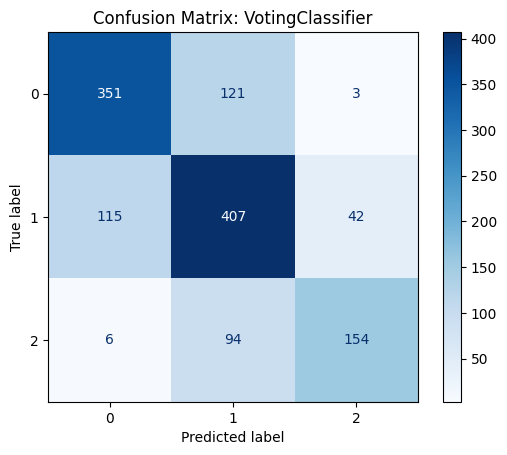


 Evaluating VotingClassifier...
              precision    recall  f1-score   support

           0       0.73      0.75      0.74       475
           1       0.66      0.71      0.68       564
           2       0.76      0.59      0.66       254

    accuracy                           0.70      1293
   macro avg       0.72      0.68      0.70      1293
weighted avg       0.71      0.70      0.70      1293



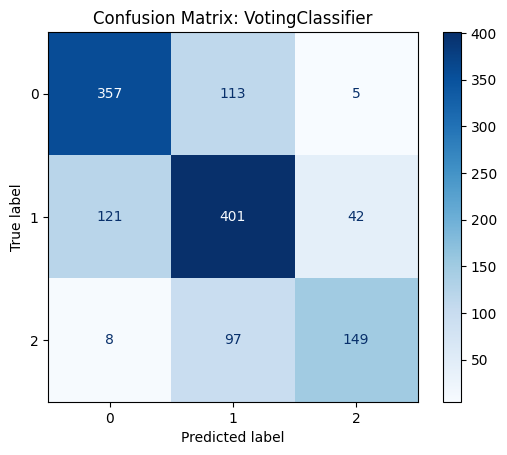

In [22]:
voting_hard.fit(X_train_scaled, y_train)
voting_soft.fit(X_train_scaled, y_train)

evaluate_models([voting_hard, voting_soft], X_test_scaled, y_test)

## Stacking (Meta-ensamble)

En esta sección implementamos otro enfoque de ensamble conocido como **Stacking** (*Stacked Generalization*), que busca combinar múltiples modelos base a través de un modelo meta-aprendizaje que aprende a partir de sus predicciones.

A diferencia del `VotingClassifier`, que simplemente cuenta votos o promedia probabilidades, el **`StackingClassifier`**:

- Entrena cada modelo base de forma independiente.
- Luego utiliza las **predicciones generadas por estos modelos** como **características de entrada** para un modelo final o **meta-modelo** (por defecto, una regresión logística).

Esto permite capturar patrones más complejos en la combinación de modelos, lo que potencialmente puede ofrecer mejoras en el rendimiento general.

### Modelos utilizados como base:

- Random Forest
- AdaBoost
- XGBoost

### Meta-modelo:

- Regresión logística (por defecto en scikit-learn)

Al igual que con los enfoques anteriores, evaluaremos el desempeño del ensamble por stacking utilizando:

- **Classification report** (con énfasis en F1-score ponderado)
- **Matriz de confusión**

Finalmente, compararemos su rendimiento con los resultados obtenidos previamente con **VotingClassifier** y con los modelos individuales.

In [23]:
estimators = [
    ('RandomForest', rf),
    ('AdaBoost', adaptiveboosting),
    ('XGBoost', xgboost_model)
]

stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000),  # Meta-modelo
    cv=stratified_cv,
    stack_method='predict_proba',
    passthrough=False  # True para incluir características originales + meta-características
)

stacking_clf.fit(X_train_scaled, y_train)
y_pred = stacking_clf.predict(X_test_scaled)

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75       475
           1       0.65      0.71      0.68       564
           2       0.73      0.59      0.66       254

    accuracy                           0.70      1293
   macro avg       0.71      0.68      0.70      1293
weighted avg       0.70      0.70      0.70      1293



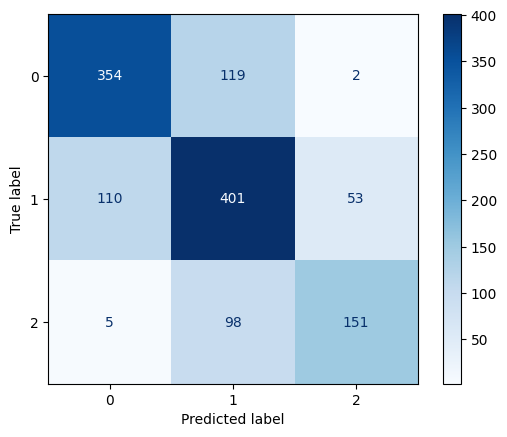

In [25]:
cm = confusion_matrix(y_test, stacking_clf.predict(X_test_scaled))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

In [26]:

estimators = [
    ('RandomForest', rf),
    ('AdaBoost', adaptiveboosting),
    ('XGBoost', xgboost_model)
]



stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=MLPClassifier(random_state=42),
    cv=stratified_cv,
    stack_method='predict_proba',
    passthrough=False
)


stacking_clf.fit(X_train_scaled, y_train)
y_pred = stacking_clf.predict(X_test_scaled)

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75       475
           1       0.65      0.72      0.68       564
           2       0.77      0.58      0.66       254

    accuracy                           0.70      1293
   macro avg       0.72      0.68      0.70      1293
weighted avg       0.71      0.70      0.70      1293



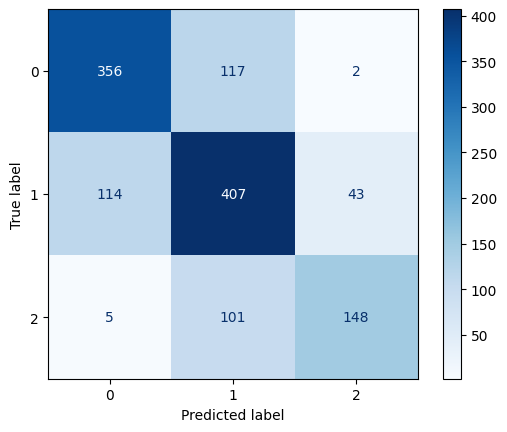

In [28]:
cm = confusion_matrix(y_test, stacking_clf.predict(X_test_scaled))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.grid(False)
plt.show()